In [2]:
# !pip install -q seaborn visualkeras
# !pip install opencv-python
# !pip install tensorflow

In [4]:
# For TensorFlow's Keras
import tensorflow.keras
print(tensorflow.keras.__file__)

# For standalone Keras, if you have it installed
import keras
print(keras.__file__)

import keras.applications.vgg19 
print(keras.applications.vgg19.__file__)



c:\Users\14158\miniconda3\envs\internship\Lib\site-packages\keras\_tf_keras\keras\__init__.py
c:\Users\14158\miniconda3\envs\internship\Lib\site-packages\keras\__init__.py
c:\Users\14158\miniconda3\envs\internship\Lib\site-packages\keras\api\applications\vgg19\__init__.py


In [5]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import plotly.graph_objects as go
from PIL import Image
import cv2
import os

import tensorflow as tf
from keras import layers
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16

from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
data_path = 'C:/Users/14158/BrodyCode/HackDavis/Datasets/FinalDataset'
data_classes = os.listdir(data_path)

In [7]:
from keras.applications.vgg16 import preprocess_input

def image_preprocessing(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


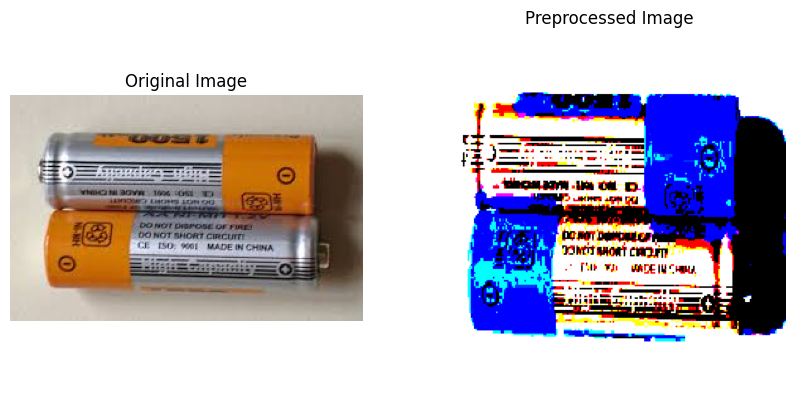

In [8]:
def plot_images(original, preprocessed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(np.squeeze(preprocessed, axis=0))
    axs[1].set_title('Preprocessed Image')
    axs[1].axis('off')
    plt.show()

img_path = 'C:/Users/14158/BrodyCode/HackDavis/Datasets/FinalDataset/battery/battery1.jpg' 
original_image = Image.open(img_path)
preprocessed_image = image_preprocessing(img_path)
plot_images(original_image, preprocessed_image)

Model Architecture:

To prevent overfitting when using VGG16, the team will apply the technique of fine-tuning the pre-trained model.
Since VGG16 has up to 21 layers, we will freeze the first 2 layers (excluding the 2 layers of data layers that will not do weight training) → Then, we will fine-tune the remaining 16 layers to avoid overfit (dropout, batch-normalization,...) to improve the quality of the model.

In [16]:
BATCH_SIZE = 64
n_classes = 6

# VGG16 base model
conv_base = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# # Freeze all layers except the last two
# for layer in conv_base.layers[:-2]:
#     layer.trainable = False

# # Fine-tune model
# top_model = conv_base.output
# top_model = Flatten(name="flatten")(top_model)
# top_model = Dense(1024, activation='relu')(top_model)  # Increased units
# top_model = BatchNormalization()(top_model)
# top_model = Dropout(0.5)(top_model)
# top_model = Dense(512, activation='relu')(top_model)  # Increased units
# top_model = BatchNormalization()(top_model)
# top_model = Dropout(0.5)(top_model)
# output_layer = Dense(n_classes, activation='softmax')(top_model)

# # Final Model
# model = Model(inputs=conv_base.input, outputs=output_layer)
# # visualkeras.layered_view(model, to_file='model_architecture.png', legend=True)





# Import necessary libraries
import tensorflow as tf
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Assuming 'conv_base' and other necessary parts of your code are defined above this section
# Freeze layers in the convolutional base
for layer in conv_base.layers[:-2]:
    layer.trainable = False

# Adding custom layers on top of the convolutional base
top_model = conv_base.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(1024, activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(512, activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.5)(top_model)
output_layer = Dense(n_classes, activation='softmax')(top_model)

# Final Model
model = Model(inputs=conv_base.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data generators
gen_train = ImageDataGenerator(preprocessing_function=preprocess_input) 
train_data = gen_train.flow_from_directory(data_path, target_size=(224, 224), batch_size=BATCH_SIZE, class_mode="categorical", shuffle=True)

# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2),
    ModelCheckpoint('model_best.keras', monitor='val_loss', save_best_only=True)
]

# Training the model
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=10,  # Adjust epochs according to your needs
    callbacks=callbacks
)

# Save the trained model
model.save('please.keras')

Found 9673 images belonging to 6 classes.
Epoch 1/10
 28/152 ━━━━━━━━━━━━━━━━━━━━ 27:14 13s/step - accuracy: 0.6586 - loss: 1.1354

KeyboardInterrupt: 

In [11]:
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 40,939,846 (156.17 MB)

 Trainable params: 28,581,894 (109.03 MB)

 Non-trainable params: 12,357,952 (47.14 MB)

Splitting the dataset to 10% test 90% trainging

In [ ]:
gen_train = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing
full_data = gen_train.flow_from_directory(data_path, target_size = (224, 224), batch_size = BATCH_SIZE, class_mode="categorical")

Found 9673 images belonging to 6 classes.


In [ ]:
filenames = full_data.filenames
labels = full_data.labels
class_mapping = {value: str(key) for key, value in full_data.class_indices.items()}
labels = [class_mapping[label] for label in labels]

# Split the data into training and testing sets
train_filenames, test_filenames, train_labels, test_labels = train_test_split(filenames, labels, test_size=0.1, random_state=42)

train_df = pd.DataFrame({'filename': train_filenames, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_filenames, 'class': test_labels})

# Create separate generators for training and testing using flow_from_dataframe
train_data = gen_train.flow_from_dataframe(train_df, directory=data_path, target_size=(224, 224),
                                           batch_size=BATCH_SIZE, class_mode="categorical",
                                           shuffle=True, seed=42)

test_data = gen_train.flow_from_dataframe(test_df, directory=data_path, target_size=(224, 224),
                                          batch_size=BATCH_SIZE, class_mode="categorical",
                                          shuffle=False)

Found 8705 validated image filenames belonging to 6 classes.
Found 968 validated image filenames belonging to 6 classes.


# VGG16
***

In [ ]:
vgg16 = load_model("C:/Users/14158/BrodyCode/HackDavis/Notebooks/please.h5")


output_class = ["battery", "glass", "metal","organic", "paper", "plastic"]

def preprocessing_input(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img) # VGG16 preprocess_input
    return img

def plot_images(original, preprocessed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Remove the batch dimension for display
    preprocessed = np.squeeze(preprocessed, axis=0)

    axs[1].imshow(preprocessed)
    axs[1].set_title('Preprocessed Image')
    axs[1].axis('off')

    plt.show()

def predict_user(img_path):
    img = preprocessing_input(img_path)
    plot_images(Image.open(img_path), img)
    predicted_array = model.predict(img)
    predicted_value = output_class[np.argmax(predicted_array)]
    predicted_accuracy = round(np.max(predicted_array) * 100, 2)
    print("Your waste material is", predicted_value, "with", predicted_accuracy, "% accuracy.")

In [ ]:
vgg16 = load_model("C:/Users/14158/BrodyCode/HackDavis/Notebooks/vgg16_weights_tf_dim_ordering_tf_kernels_notop.keras")

predictions = vgg16.predict(test_data)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_data.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))


model.save('please.keras')

ValueError: File not found: filepath=C:/Users/14158/BrodyCode/HackDavis/Notebooks/vgg16_weights_tf_dim_ordering_tf_kernels_notop.keras. Please ensure the file is an accessible `.keras` zip file.

ModuleNotFoundError: No module named 'keras'

In [ ]:
model.save('C:/Users/14158/BrodyCode/HackDavis/Models/please.h5')

In [ ]:
predictions = vgg19.predict(test_data)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_data.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))